# Procrustes-like alignment for SPD matrices

In this notebook I will perform some simulations to check the results from the report (I will report here the results that I will check without a proof).

The general problem is to find the *optimal* way to align a set of SPD matrices to a common reference. This problem can be split in two parts:

  1. given a reference, what is the optimal rotation for each matrix in the set?
  2. which is the optimal reference
 
I start by importing the used packages and defining the hyperparameters

In [1]:
import jax.numpy as jnp
from jax import random, jit, partial

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme('talk', 'darkgrid')

from jax.config import config
config.update("jax_enable_x64", True)

plt.rcParams["figure.figsize"] = (18,6)

seed = 0
rng = random.PRNGKey(seed)

# Hyperparameters: number of matrices and their dimensions
n, p = 10, 3

# Hyperparameters: simulations numbers
n_tests = 5
n_rep = 30

Then I generate a set of random SPD matrices $\Sigma_i$ that we can consider a sample dataset.

In [2]:
rng, key = random.split(rng)
Sigmas = random.normal(key, shape=(n, p, p))
Sigmas = jnp.einsum('...ij,...kj', Sigmas, Sigmas)

Then I define the various function that I will need (along with some helper utilities). Mainly, I will need the distance induced by the Frobenius norm
$$
    d_F(A, B)^2 = \left\Vert A-B\right\Vert^2_F = tr\left((A-B)^\top(A-B)\right)
$$
the riemannian distance (with $Log$ the matrix logarithm, which for the SPD matrices is well defined)
$$
    d_R(A, B)^2 = \left\Vert Log\left(A^{-1/2}BA^{-1/2}\right)\right\Vert^2_F
$$

Moreover, the rotation in this context is defined as
$$
    T_\Omega(\Sigma) = \Omega\Sigma\Omega^\top
$$

In [3]:
# Functions
isqrt = lambda x: 1. / jnp.sqrt(x)
funs = {'sqrt': jnp.sqrt,
        'isqrt': isqrt,
        'log': jnp.log,
        'exp': jnp.exp}

@jit
def norm_frob_squared(X):
    return jnp.einsum('...ji,...ji', X, X)

@jit
def dist_frob_squared(X, Y):
    return norm_frob_squared(X - Y)

@partial(jit, static_argnums=(1))
def transform_mat(X, func='sqrt'):
    u, v = jnp.linalg.eigh(X)
    return jnp.einsum('...ij,...j,...kj', v, funs[func](u), v)

@jit
def dist_riem_squared(X, Y):
    x = transform_mat(X, 'isqrt')
    mid = jnp.einsum('...ij,...jk,...kl', x, Y, x)
    return norm_frob_squared(transform_mat(mid, 'log'))

@jit
def costfunc(X, Y):
    return jnp.sum(dist_riem_squared(X, Y))

@jit
def rotate(X, Omega):
    return jnp.einsum('...ij,...jk,...lk', Omega, X, Omega)



## Results from the report
As is proven in the report, the set of optimal rotation matrices, given the eigenvalue decompositions $\Gamma_i\Lambda_i\Gamma_i^\top = \Sigma_i$ and $\Gamma_M\Lambda_M\Gamma_M=M$ is
$$
    \Omega_i = \Gamma_M\Gamma_i^\top
$$

The optimal reference matrix is obtained by combining the optimal eigenvalues and the optimal eigenvectors, which are separately
$$
    \lambda_{Mh} = \left[\prod_i^n\lambda_{ih}\right]^{1/n}
$$
and
$$
    \Gamma_M = UV^\top
$$
with $UDV^\top = \sum_i\Gamma_i$ the singular value decomposition of the sum of $\Gamma_i$

In [4]:
@jit
def optimal_rotation(X, M):
    _, g_m = jnp.linalg.eigh(M)
    _, g_x = jnp.linalg.eigh(X)
    return jnp.einsum('...ij,...kj', g_m, g_x)

@jit
def optimal_reference_eigval(X):
    u = jnp.linalg.eigvalsh(X)
    return jnp.power(jnp.prod(u, axis=0), 1 / X.shape[0])

@jit
def optimal_reference_eigvec(X):
    _, vs = jnp.linalg.eigh(Sigmas)
    U, _, V = jnp.linalg.svd(jnp.sum(vs, axis=0))
    return jnp.einsum('...ij,...jk', U, V)

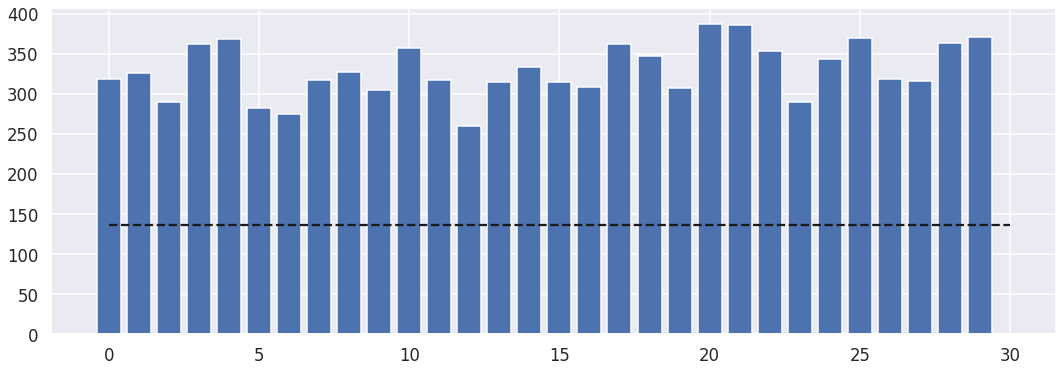

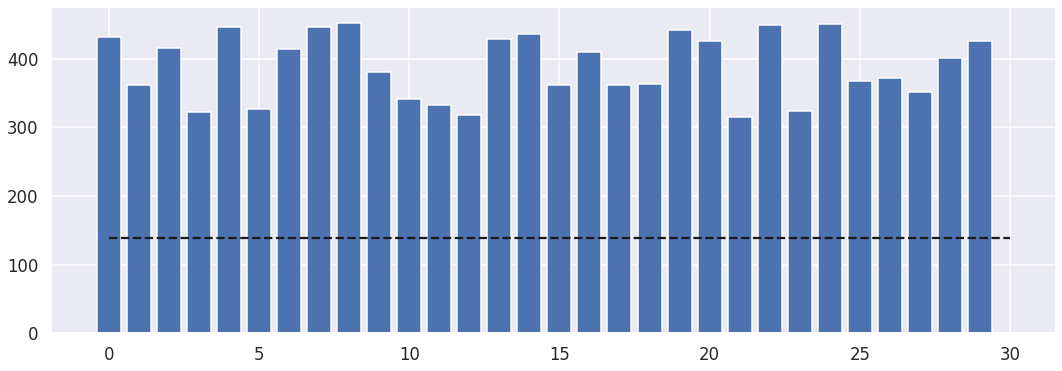

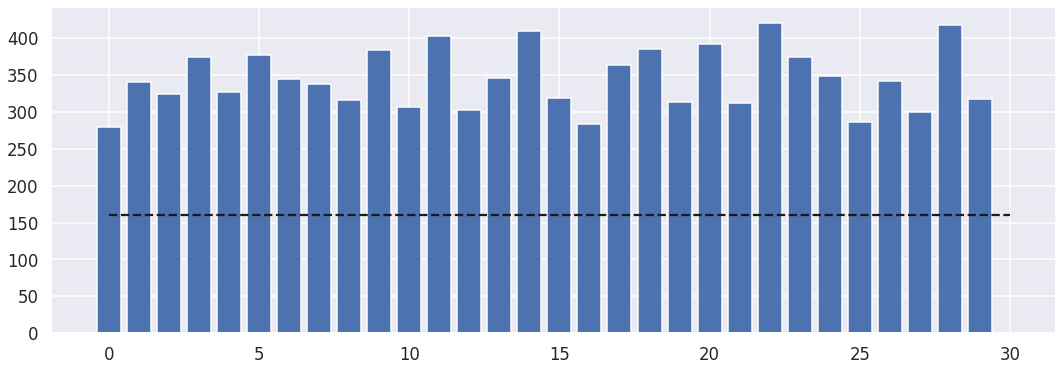

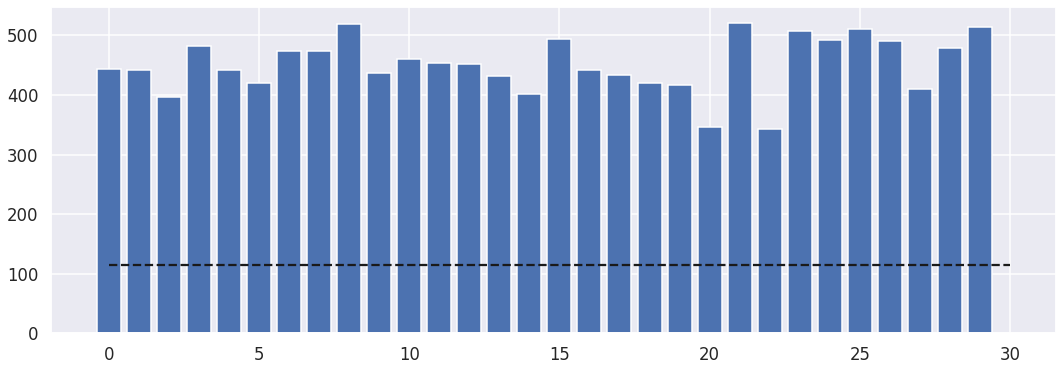

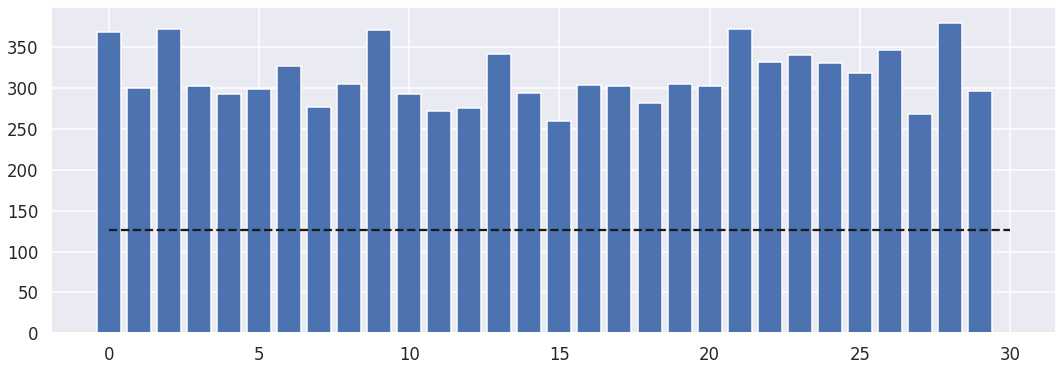

In [5]:
# First simulation: optimal rotation
rng, *key = random.split(rng, n_tests + 1)

for i in range(n_tests):
    k, *ks = random.split(key[i], n_rep + 1)
    M = random.normal(k, shape=(p, p))
    M = jnp.einsum('...ij,...kj', M, M)
    
    om_opt = optimal_rotation(Sigmas, M)
    cost_opt = costfunc(M, rotate(Sigmas, om_opt))
    cost_om = []
    
    for j in range(n_rep):
        omega = jnp.linalg.qr(random.normal(ks[j], shape=(p, p)))[0]
        cost_om.append(costfunc(M, rotate(Sigmas, omega)))
    
    plt.bar(range(n_rep), cost_om)
    plt.hlines(y=cost_opt, xmin=0, xmax=n_rep, colors='k', linestyle='dashed')
    plt.show()

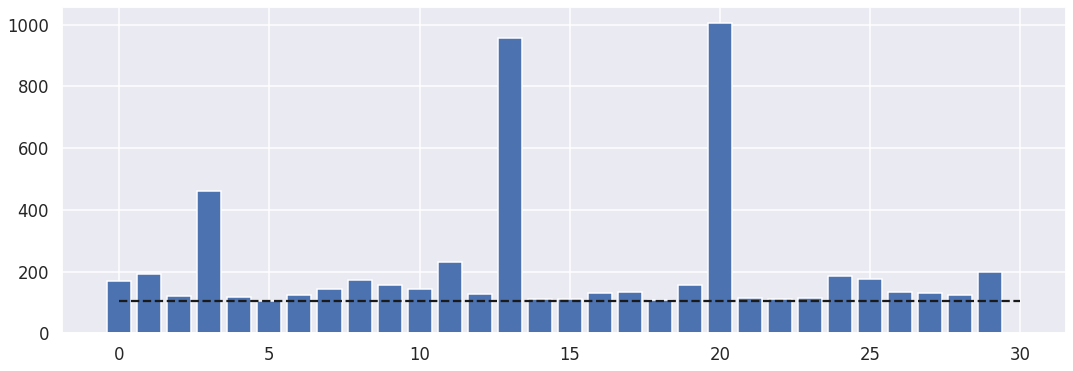

In [6]:
# Second simulation: Eigenvalues of the optimal reference
rng, *key = random.split(rng, n_rep + 1)

lam_opt = jnp.diag(optimal_reference_eigval(Sigmas))
rot_opt = optimal_rotation(Sigmas, lam_opt)
cost_opt = costfunc(lam_opt, rotate(Sigmas, rot_opt))

costs = []

for j in range(n_rep):
    M = random.normal(key[j], shape=(p, p))
    M = jnp.einsum('...ij,...kj', M, M)
    rot = optimal_rotation(Sigmas, M)
    costs.append(costfunc(M, rotate(Sigmas, rot)))

plt.bar(range(n_rep), costs)
plt.hlines(y=cost_opt, xmin=0, xmax=n_rep, colors='k', linestyle='dashed')
plt.show()

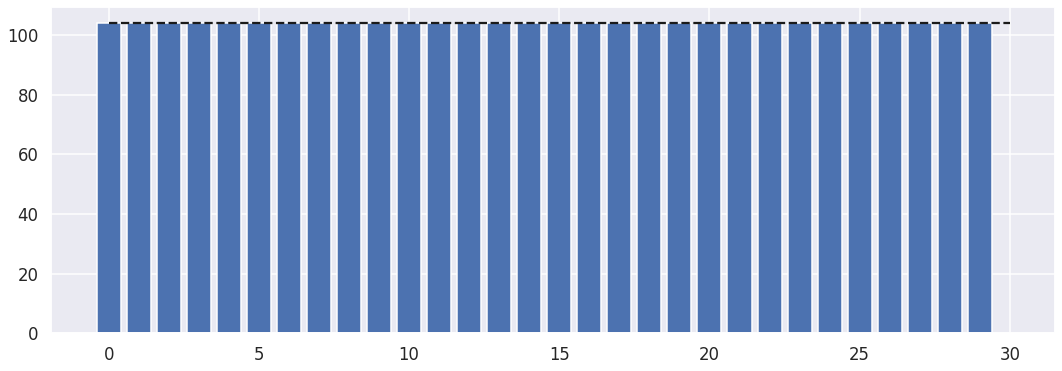

In [7]:
# Third simulation: Independence from the eigenvectors
rng, *key = random.split(rng, n_rep + 1)

lam_opt = optimal_reference_eigval(Sigmas)
rot_opt = optimal_rotation(Sigmas, jnp.diag(lam_opt))
cost_opt = costfunc(jnp.diag(lam_opt), rotate(Sigmas, rot_opt))

costs = []

for j in range(n_rep):
    M = jnp.linalg.qr(random.normal(key[j], shape=(p, p)))[0]
    M = jnp.einsum('...ij,...j,...kj', M, lam_opt, M)
    rot = optimal_rotation(Sigmas, M)
    costs.append(costfunc(M, rotate(Sigmas, rot)))

plt.bar(range(n_rep), costs)
plt.hlines(y=cost_opt, xmin=0, xmax=n_rep, colors='k', linestyle='dashed')
plt.show()

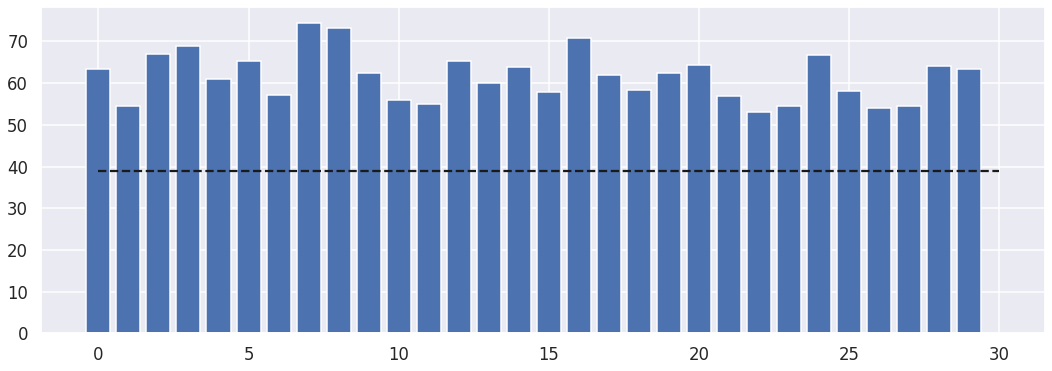

In [8]:
# Fourth simulation: Eigenvectors of optimal reference
cost_procr = jit(lambda x, y: jnp.sum(dist_frob_squared(x, y)))

_, vs = jnp.linalg.eigh(Sigmas)
U, _, V = jnp.linalg.svd(jnp.sum(vs, axis=0))

opt_gam = jnp.einsum('...ij,...jk', U, V)
opt_cost = cost_procr(jnp.einsum('...ij,...kj', opt_gam, vs), jnp.identity(p))

rng, *key = random.split(rng, n_rep + 1)
costs = []

for j in range(n_rep):
    M = jnp.linalg.qr(random.normal(key[j], shape=(p, p)))[0]
    costs.append(cost_procr(jnp.einsum('...ij,...kj', M, vs), jnp.identity(p)))
    if costs[-1] < opt_cost:
        print(M)
        print(opt_gam)

plt.bar(range(n_rep), costs)
plt.hlines(y=opt_cost, xmin=0, xmax=n_rep, colors='k', linestyle='dashed')
plt.show()